# Zero Noise Extrapolation with Qiskit (upgrade implementation from Thức's project)

## I. Import Library

Firstly, let's import some classical libraries for the Zero Noise Extrapolation.

In [353]:
import time
import numpy as np
import matplotlib.pyplot as plt

Next, we will import quantum libraries

In [354]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
from qiskit.quantum_info import state_fidelity, DensityMatrix

## II. Make some neccesary function

1. Create ideal GHZ circuit

In [355]:
def create_GHZ_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    return qc

2. Make Noise Model

In [356]:
def make_noise_model(p):
    noise_model = NoiseModel()

    error_1q = pauli_error([('X', p/3), ('Y', p/3), ('Z', p/3), ('I', 1 - p)])
    error_2q = error_1q.tensor(error_1q)

    noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    return noise_model

3. Set up Aer Simulation with Noise Model

In [357]:
def set_up_simu(p):
    noise_model = make_noise_model(p)
    noise_simulator = AerSimulator(method='density_matrix', noise_model=noise_model)
    return noise_simulator

4. Create noisy GHZ circuit (use depolarizing noise)

In [358]:
def noisy_GHZ_circuit(num_qubits, simulator):
    ideal_GHZ_circuit = create_GHZ_circuit(num_qubits) 
    ideal_GHZ_circuit.save_density_matrix()
    compiled_circuit = transpile(ideal_GHZ_circuit, simulator)

    return compiled_circuit


5. Running noise GHZ simulation

Input: 

    - Number of qubits (num_qubits)

    - Depolarizing error gate (p)

Output: 

    - Ideal GHZ circuit (default is False)

    - Noise GHZ circuit compiled for AerSimulator

    - Result when run noise GHZ circuit simulation

    - Execution time when run noise GHZ circuit simulation

In [359]:
def set_noise_exp(num_qubits, p):  
    noise_simulator = set_up_simu(p)
    compiled_noise_circuit = noisy_GHZ_circuit(num_qubits, noise_simulator)

    start_time = time.time()
    result = noise_simulator.run(compiled_noise_circuit).result()
    end_time = time.time()
    
    return compiled_noise_circuit, result, end_time - start_time

6. Fidelity between ideal GHZ circuit vs noise GHZ circuit

In [360]:
def fidelity_ideal_noise(ideal_circuit, noise_result):
    ideal_state = DensityMatrix.from_instruction(ideal_circuit)
    noisy_state = DensityMatrix(noise_result.data(0)['density_matrix'])

    return state_fidelity(ideal_state, noisy_state)

## III. Qubit sizes vs Noise levels

In [361]:
qubit_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
noise_levels = [0.2, 0.3, 0.4, 0.5]

## IV. Run Code

In [362]:
scalability_results = []
execution_times = []
fidelities = []

for num_qubits in qubit_sizes:
    print(f"\nRunning scalability test for {num_qubits} qubits...")

    ideal_ghz_circuit = create_GHZ_circuit(num_qubits)
    compiled_noise_circuit, noise_result, execution_time = set_noise_exp(num_qubits, noise_levels[0])
    
    fidelity_before_ZNE = fidelity_ideal_noise(ideal_ghz_circuit, noise_result)
    execution_times.append(execution_time)

    print(f"  Fidelity before ZNE: {fidelity_before_ZNE:.4f} | Execution Time: {execution_time:.4f} sec")

    # Zero-Noise Extrapolation (ZNE)
    qubit_fidelities = []
    for noise in noise_levels:
        compiled_noise_circuit, noise_result, execution_time = set_noise_exp(num_qubits, noise)
        fidelity = fidelity_ideal_noise(ideal_ghz_circuit, noise_result)
        qubit_fidelities.append(fidelity)

    fit = np.polyfit(noise_levels, qubit_fidelities, deg=2)
    zero_noise_fidelity = np.polyval(fit, 0)
    fidelities.append(zero_noise_fidelity)

    print(f"  Extrapolated zero-noise fidelity (after ZNE): {zero_noise_fidelity:.4f}")
    scalability_results.append((num_qubits, fidelity_before_ZNE, zero_noise_fidelity))


Running scalability test for 2 qubits...
  Fidelity before ZNE: 0.5816 | Execution Time: 0.0030 sec
  Extrapolated zero-noise fidelity (after ZNE): 0.9577

Running scalability test for 3 qubits...
  Fidelity before ZNE: 0.3969 | Execution Time: 0.0000 sec
  Extrapolated zero-noise fidelity (after ZNE): 0.7972

Running scalability test for 4 qubits...
  Fidelity before ZNE: 0.2765 | Execution Time: 0.0137 sec
  Extrapolated zero-noise fidelity (after ZNE): 0.6286

Running scalability test for 5 qubits...
  Fidelity before ZNE: 0.1962 | Execution Time: 0.0030 sec
  Extrapolated zero-noise fidelity (after ZNE): 0.4888

Running scalability test for 6 qubits...
  Fidelity before ZNE: 0.1414 | Execution Time: 0.0157 sec
  Extrapolated zero-noise fidelity (after ZNE): 0.3796

Running scalability test for 7 qubits...
  Fidelity before ZNE: 0.1031 | Execution Time: 0.0140 sec
  Extrapolated zero-noise fidelity (after ZNE): 0.2949

Running scalability test for 8 qubits...
  Fidelity before ZNE:

## V. Extrapolate to Zero-Noise Fidelity (quadratic fit)

In [363]:
'''fit = np.polyfit(noise_levels, qubit_fidelities, deg=2)
zero_noise_fidelity = np.polyval(fit, 0)
fidelities.append(zero_noise_fidelity)

print(f"  Extrapolated zero-noise fidelity (after ZNE): {zero_noise_fidelity:.4f}")
scalability_results.append((num_qubits, fidelity_before_ZNE, zero_noise_fidelity))'''

'fit = np.polyfit(noise_levels, qubit_fidelities, deg=2)\nzero_noise_fidelity = np.polyval(fit, 0)\nfidelities.append(zero_noise_fidelity)\n\nprint(f"  Extrapolated zero-noise fidelity (after ZNE): {zero_noise_fidelity:.4f}")\nscalability_results.append((num_qubits, fidelity_before_ZNE, zero_noise_fidelity))'

## VI. Plot scalability results

(2, 3, 4, 5, 6, 7, 8, 9, 10)
(0.5816296354778335, 0.39685663031299373, 0.27648833189103983, 0.1962238661314473, 0.14137707089002688, 0.103073279628569, 0.07583037391485443, 0.05616806308877122, 0.0418136703529849)
(np.float64(0.9576888947086923), np.float64(0.7971950689232674), np.float64(0.6285637534490752), np.float64(0.48884382358797746), np.float64(0.37959890946680036), np.float64(0.2949214456238677), np.float64(0.2290782995540666), np.float64(0.17769705316125914), np.float64(0.13754881710430078))


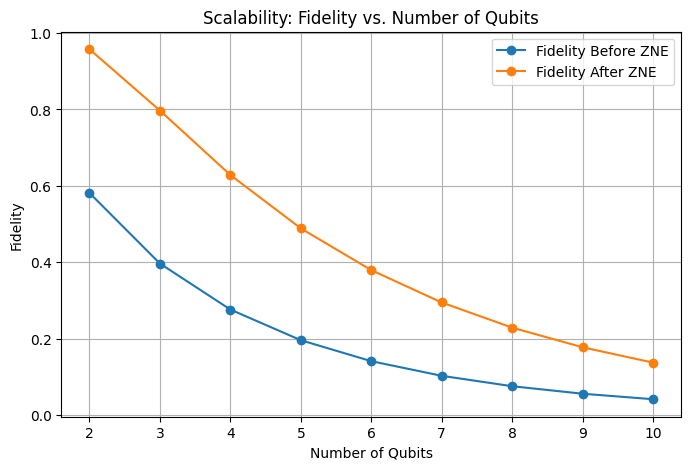

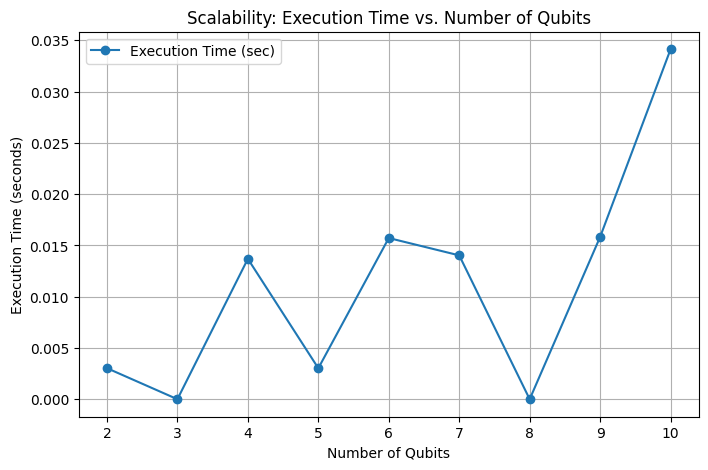

In [364]:
num_qubits_list, fidelities_before, fidelities_after = zip(*scalability_results)
print(num_qubits_list)
print(fidelities_before)
print(fidelities_after)

plt.figure(figsize=(8, 5))
plt.plot(num_qubits_list, fidelities_before, 'o-', label="Fidelity Before ZNE")
plt.plot(num_qubits_list, fidelities_after, 'o-', label="Fidelity After ZNE")
plt.xlabel("Number of Qubits")
plt.ylabel("Fidelity")
plt.legend()
plt.title("Scalability: Fidelity vs. Number of Qubits")
plt.grid()
plt.show()

# Plot execution time vs number of qubits
plt.figure(figsize=(8, 5))
plt.plot(qubit_sizes, execution_times, 'o-', label="Execution Time (sec)")
plt.xlabel("Number of Qubits")
plt.ylabel("Execution Time (seconds)")
plt.legend()
plt.title("Scalability: Execution Time vs. Number of Qubits")
plt.grid()
plt.show()